
# Unsupervised Algoritms in Machine Learning
## Week 4 BBC News Classification Kaggle Mini Project

This project will use matrix factorization algorithms to categorize news articles and then compare the results to supervised classification models.

### Import Libraries

The following libraries will be used in my project.

In [408]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



### Load the Data

In [316]:
train = pd.read_csv('BBC News Train.csv')
test = pd.read_csv('BBC News Test.csv')
solution = pd.read_csv('BBC News Sample Solution.csv')


### EDA

In my exploratory data analysis I first check for any null values. I create a histogram plot of count totals for each category and also look at text size of each article.

In [1]:
print("train dimensions: ", train.shape)
print("test dimensions: ", test.shape)
print(train.describe())

#Checking for null values
print("\nTrain null values?: ",train.isnull().values.any())
print("Test null values?: ",test.isnull().values.any())
      

sns.histplot(train['Category'])
sns.histplot(train['Category'])
plt.title("Category Counts")
plt.show()

print(train.info())

text_lengths = []
for i in train.Text:
    text_lengths.append(len(i))
    
sns.histplot(text_lengths)
plt.title("Text Lengths")
plt.show()

NameError: name 'train' is not defined

### Cleaning

**Text to Feature Vector**

Here I convert the matrix into Term Frequency-Inverse Document Frequency matrix. TF-IDF captures the significance of a word in a document relative to the collection of documents.

It is calculated by the following equations:

term frequency = count of word in article / number of words in article

document frequency = number of articles that contain the word

inverse document frequency = log(number of documents/document frequency)

The final matrix is a weighted matrix calculated from:

tf-idf(t, d) = term frequency(t, d) * inverse document frequency(t)

Using TFID, a matrix of M rows corresponding to the articles and N columns corresponding to the weighted word count statistics is created. 

In [416]:
# change categories to numeric


tfidf_vect = TfidfVectorizer(sublinear_tf=True,
                            max_df=0.95,
                            min_df=round(len(train)*0.01),
                            stop_words="english")

tfidf_vect.fit(train["Text"])
tfidf_train = tfidf_vect.transform(train["Text"])
tfidf_test = tfidf_vect.transform(test["Text"])
print(tfidf_train.shape)
tfidf_vect.get_feature_names_out()
tfidf_vect.get_feature_names_out()


KeyError: 'text'

**Dimensionality Analysis**

The plot below shows the groups are decently separted for our modeling purposes.


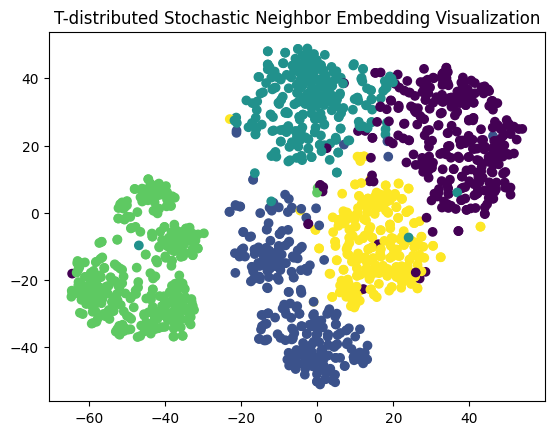

In [322]:
tsne = TSNE(n_components=2, init= 'random',random_state=42)
tsne_train = tsne.fit_transform(tfidf_train)

plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c=train['Category'].astype('category').cat.codes)
plt.title("T-distributed Stochastic Neighbor Embedding Visualization")
plt.show()

### Models

I first create unsupervised models using Frobenius and Kullback-Leibler divergence methods. With these models I show top words per category. Then I create supervised models using Random Forrest Classifier, Logistic Regression and Linear SVC approaches.

(1490, 5)
NMF-Frobenius Train Accuracy: 0.938255033557047
Labels: {4: 'business', 3: 'entertainment', 2: 'politics', 1: 'sport', 0: 'tech'}
For category tech the words with the highest value are:
people        0.472882
users         0.399332
technology    0.389212
mobile        0.371497
software      0.341505
use           0.336429
digital       0.335963
phone         0.315216
music         0.300056
net           0.293725
Name: 0, dtype: float64


For category sport the words with the highest value are:
game       0.385888
win        0.322991
england    0.310943
cup        0.268394
team       0.259309
play       0.251847
match      0.251032
players    0.242829
season     0.238065
time       0.236358
Name: 1, dtype: float64


For category politics the words with the highest value are:
mr            0.456900
labour        0.423743
election      0.404431
blair         0.369009
party         0.349141
government    0.331253
minister      0.291917
said          0.262914
prime         0.24624

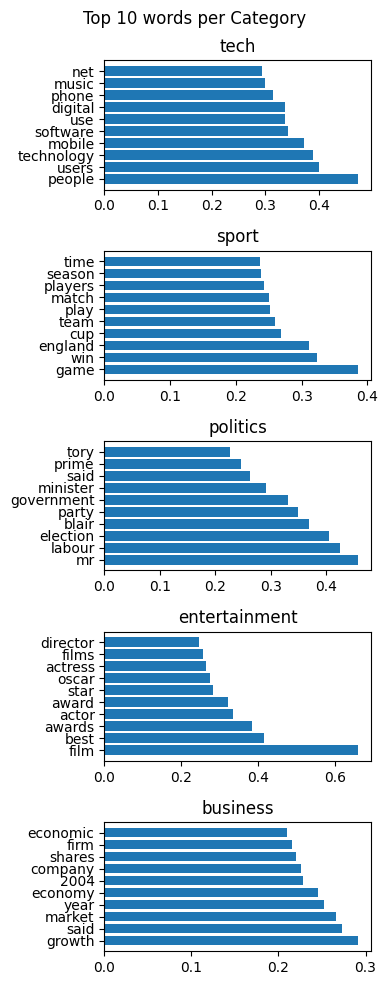

In [350]:
##########################
## Unsupervised Models
##########################

categories = train["Category"].nunique()


##########################
## Frobenius Model
##########################

nmf_fro = NMF(categories, random_state=0)
nmf_model_fro = nmf.fit(tfidf_train)

nmf_features_fro = nmf_model_fro.transform(tfidf_train)
print(nmf_features.shape)

y_pred = np.array([np.argmax(i) for i in nmf_model_fro.transform(tfidf_train)])

label_map, nmf_acc = label_permute_compare(train.Category, y_pred)
print("NMF-Frobenius Train Accuracy:", nmf_acc)
print("Labels:", label_map)


components_df = pd.DataFrame(nmf_model_fro.components_, columns=tfidf_vect.get_feature_names_out())

fig = plt.subplots(5, 1, figsize=(4, 10))
plt.suptitle("Top 10 words per Category")

nrow = components_df.shape[0]
for cat in range(components_df.shape[0]):
    tmp = components_df.iloc[cat]
    label = label_map[cat]
    print(f'For category {label} the words with the highest value are:')
    indexes = list(tmp.nlargest(10).index)
    print(tmp.nlargest(10))
    print('\n')
    plt.subplot(nrow, 1, cat+1)
    plt.title(label)
    plt.barh(indexes,tmp.nlargest(10).values)

plt.tight_layout()    
plt.show  


# Frobenius Model using test data
y_pred_test = np.array([np.argmax(i) for i in nmf.transform(tfidf_test)])
test_predicted_labels = list(map(lambda value: label_map[value], y_pred_test))

#create csv for kaggle submission
submission_fro = pd.DataFrame({'ArticleId': test['ArticleId'],
                           'Category': test_predicted_labels})
#submission_fro.to_csv('submission_fro.csv', index=False)

#KAGGLE SCORE: 0.93877
ks_fro = 0.93877

#########################
#########################


Kullback-Leibler Train Accuracy: 0.951006711409396
Labels: {4: 'business', 3: 'entertainment', 2: 'politics', 1: 'sport', 0: 'tech'}
For category tech the words with the highest value are:
people        0.348395
technology    0.297033
users         0.272332
use           0.266002
mobile        0.256040
software      0.255868
phone         0.245572
said          0.244077
internet      0.238629
online        0.227808
Name: 0, dtype: float64


For category sport the words with the highest value are:
game       0.395912
win        0.334432
england    0.305922
team       0.283447
said       0.276184
cup        0.271087
match      0.266110
season     0.262028
players    0.260335
club       0.259644
Name: 1, dtype: float64


For category politics the words with the highest value are:
mr            0.535421
government    0.399814
labour        0.378071
election      0.370070
said          0.369012
blair         0.336460
party         0.332937
minister      0.317073
people        0.244046
publi

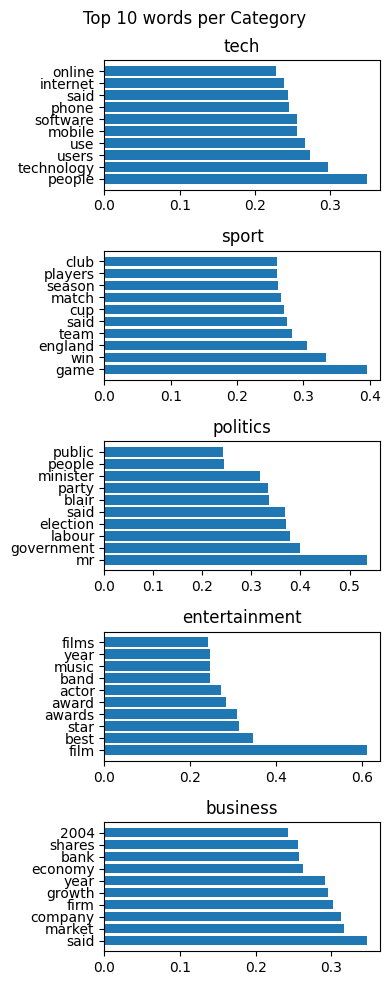

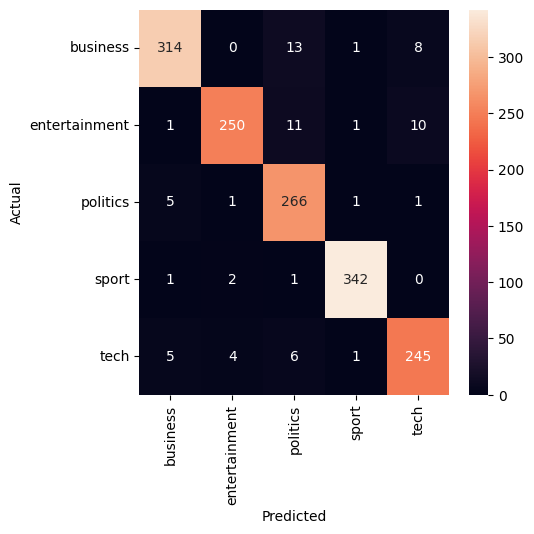

In [351]:
##########################
## Kullback-Leibler model 
##########################

nmf_kl = NMF(categories,solver = 'mu', beta_loss= 'kullback-leibler', random_state=0)
model_nmf_kl = nmf_kl.fit(tfidf_train)

nmf_kl_features = model_nmf_kl.transform(tfidf_train)

y_pred = np.array([np.argmax(i) for i in nmf_kl.transform(tfidf_train)])

label_map, nmf_kl_acc = label_permute_compare(train.Category, y_pred)

print("Kullback-Leibler Train Accuracy:", nmf_kl_acc)
print("Labels:", label_map)


components_df_kl = pd.DataFrame(model_nmf_kl.components_, columns=tfidf_vect.get_feature_names_out())

fig = plt.subplots(5, 1, figsize=(4, 10))
plt.suptitle("Top 10 words per Category")

nrow = components_df_kl.shape[0]
for cat in range(components_df_kl.shape[0]):
    tmp = components_df_kl.iloc[cat]
    label = label_map[cat]
    print(f'For category {label} the words with the highest value are:')
    indexes = list(tmp.nlargest(10).index)
    print(tmp.nlargest(10))
    print('\n')
    plt.subplot(nrow, 1, cat+1)
    plt.title(label)
    plt.barh(indexes,tmp.nlargest(10).values)
    
plt.tight_layout() 
plt.show  


# Kullback-Leibler using test data
y_pred_test_kl = np.array([np.argmax(i) for i in nmf_kl.transform(tfidf_test)])
test_predicted_labels_kl = list(map(lambda value: label_map[value], y_pred_test_kl))

#create csv for kaggle submission
submission_kl = pd.DataFrame({'ArticleId': test['ArticleId'],
                           'Category': test_predicted_labels_kl})
submission_kl.to_csv('submission_kl.csv', index=False)

# KAGGLE SCORE: 0.93741
ks_kl = 0.93741
train_predicted_labels_kl = list(map(lambda value: label_map[value], y_pred))
conf_mat = confusion_matrix(train.Category, train_predicted_labels_kl)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=np.unique(train['Category']), yticklabels=np.unique(train['Category']))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#######################
#######################

Random Forest Train Accuracy: 0.8879194630872483


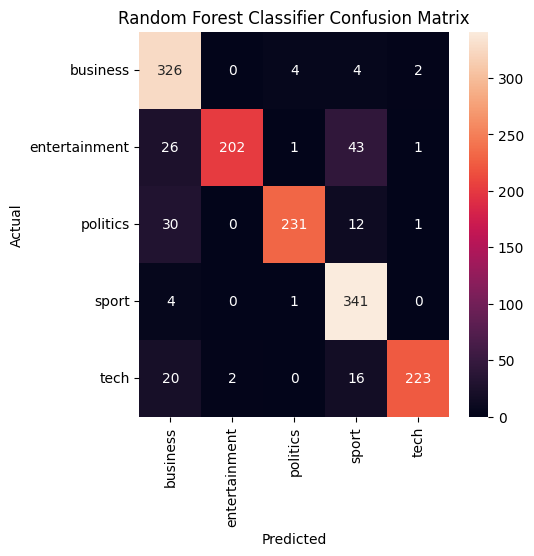

Logistic Regression Train Accuracy: 0.9966442953020134


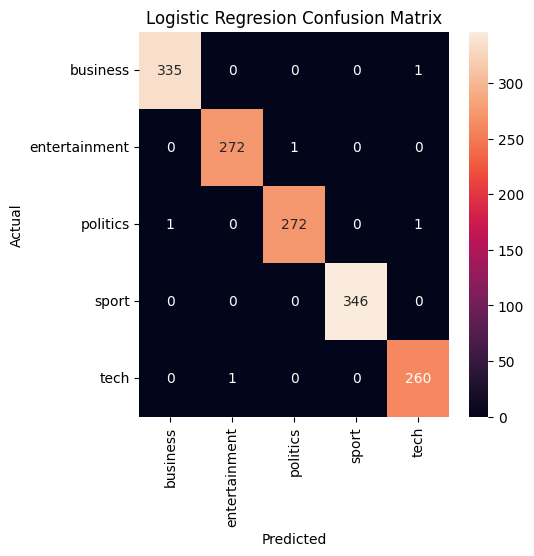

Linear SVC Train Accuracy: 1.0


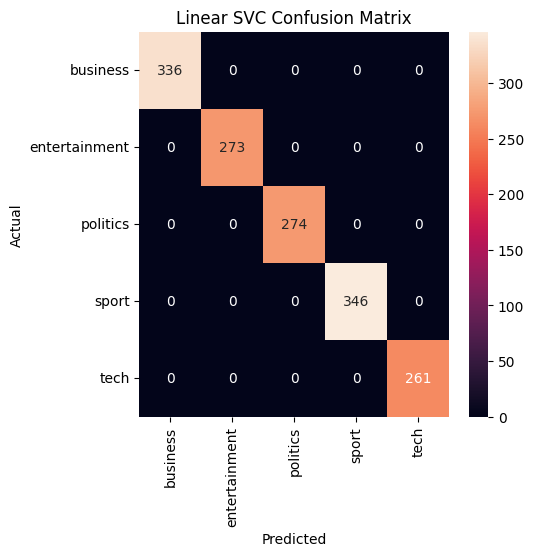

In [406]:
##########################
## Supervised Models
##########################
##########################
## RandomForestClassifier
##########################
clf = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)  
clf.fit(tfidf_train, train.Category)

y_pred = clf.predict(tfidf_train)


rfc_acc = accuracy_score(train.Category, y_pred)
print("Random Forest Train Accuracy:", rfc_acc)


y_pred_rfc = clf.predict(tfidf_test)

#create csv for kaggle submission
submission_rfc = pd.DataFrame({'ArticleId': test['ArticleId'],
                           'Category': y_pred_rfc})


#submission_rfc.to_csv('submission_rfc.csv', index=False)
#### KAGGLE SCORE 0.87619
ks_rfc =  0.87619


#Confusion Matrix
labels = np.unique(train["Category"])
conf_mat = confusion_matrix(train.Category, y_pred)

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=np.unique(train['Category']), yticklabels=np.unique(train['Category']))
plt.title("Random Forest Classifier Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
##########################
## Logistic Regression
##########################


labels=  train["Category"]

log_reg = LogisticRegression(random_state=0)
log_reg.fit(tfidf_train, list(labels))

y_pred = log_reg.predict(tfidf_train)
log_reg_acc = accuracy_score(train.Category, y_pred)
print("Logistic Regression Train Accuracy:", log_reg_acc)

y_pred_logreg = log_reg.predict(tfidf_test)

#create csv for kaggle submission
submission_logreg = pd.DataFrame({'ArticleId': test['ArticleId'],
                           'Category': y_pred_logreg})
#submission_logreg.to_csv('submission_logreg.csv', index=False)
#### KAGGLE SCORE 0.97959
ks_lr = 0.97959


#Confusion Matrix
labels = np.unique(train["Category"])
conf_mat = confusion_matrix(train.Category, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=np.unique(train['Category']), yticklabels=np.unique(train['Category']))
plt.title("Logistic Regresion Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



##########################
## Linear SVC
##########################

lsvc= LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

lsvc.fit(tfidf_train, train["Category"])
y_pred = lsvc.predict(tfidf_train)
lsvc_acc = accuracy_score(train.Category, y_pred)
print("Linear SVC Train Accuracy:", lsvc_acc)

y_pred_lsvc = lsvc.predict(tfidf_test)

#create csv for kaggle submission
submission_lsvc = pd.DataFrame({'ArticleId': test['ArticleId'],
                           'Category': y_pred_lsvc})


#submission_lsvc.to_csv('submission_lsvc.csv', index=False)
#### KAGGLE SCORE 0.98095
ks_lsvc = 0.98095

#Confusion Matrix
labels = np.unique(train["Category"])
conf_mat = confusion_matrix(train.Category, y_pred)

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=np.unique(train['Category']), yticklabels=np.unique(train['Category']))
plt.title("Linear SVC Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()




In [407]:
import itertools
from itertools import permutations


def label_permute_compare(ytdf,yp):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    {3:'business', 4:'entertainment', 1:'politics', 2:'sport', 0:'tech'}, 0.74
    """
    y_true = np.array(ytdf).reshape(-1)
    uniq_labels = np.unique(y_true)
    perm = itertools.permutations(range(len(uniq_labels)))
    best_p, best_acc = None, 0
    for p in perm:
        p_label_map = {label: int_label for label, int_label in zip(uniq_labels, p)}
        p_labels = np.array([p_label_map[label] for label in y_true])
        acc = np.mean(p_labels == yp)
        if acc > best_acc:
            best_p = {num: l for num, l in zip(p, uniq_labels)}
            best_acc = acc
    return best_p, best_acc



### Hyper-Parameter Testing

Grid Search was used to find the optimum parameters for the unsupervised models. The best parameters for highest accuracy were as follows:

|TFIDF||
|:----|:--------:|
|max_df| 0.75 |
|min_df| 7 |


|NMF||
|:----|:--------:|
|alpha_W| 0 |
|l1_ratio| 0.25 |



In [410]:
###
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, stop_words='english')),
    ('nmf', NMF(categories,solver = 'mu', beta_loss= 'kullback-leibler', random_state=0))
])

params = [{
    'tfidf__max_df': [0.75, 0.85, 0.95],
    'tfidf__min_df': [round(len(train)*0.005), round(len(train)*0.01), round(len(train)*0.02)],
    'nmf__alpha_W': [0, 0.05, 0.1],
    'nmf__l1_ratio': [0.25, 0.5, 0.75]
}]

grid_search = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(train["Text"],train["Category"])

print('Optimal Hyperparameters: ', grid_search.best_params_)
###

Optimal Hyperparameters:  {'nmf__alpha_W': 0, 'nmf__l1_ratio': 0.25, 'tfidf__max_df': 0.75, 'tfidf__min_df': 7}


### Subset of Training Data

Now I will compare the preformance of NMF, Logistic Regression and Linear SVC methods with a smaller subest of the data using hyperparameters from above.

In [396]:
######
# Creating a random sampled subset of training data
#####

samples = round(train.shape[0]*0.2)
rng = np.random.default_rng()
new_train = pd.DataFrame(rng.choice(train, size=samples, replace=False))
new_train.columns = ['ArticleID','Text','Category']

tfidf_vect = TfidfVectorizer(sublinear_tf=True,
                            max_df=0.75,
                            min_df=round(len(train)*0.005),
                            stop_words="english")

tfidf_vect.fit(new_train["Text"])
tfidf_new_train = tfidf_vect.transform(new_train["Text"])


###Applying NMF Kullback-Leibler model with new hyperparameters
new_nmf_kl = NMF(categories,solver = 'mu', beta_loss= 'kullback-leibler', l1_ratio = 0.25, random_state=0)
model_nmf_kl = new_nmf_kl.fit(tfidf_new_train)

new_y_pred = np.array([np.argmax(i) for i in new_nmf_kl.transform(tfidf_new_train)])
label_map, new_nmf_kl_acc = label_permute_compare(new_train.Category, new_y_pred)

print("Kullback-Leibler Train Accuracy- with subset:", new_nmf_kl_acc)
print("Labels:", label_map)


###Applying Linear SVC model
labels=  new_train["Category"]

new_lsvc= LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

new_lsvc.fit(tfidf_new_train, list(labels))
new_y_pred = new_lsvc.predict(tfidf_new_train)
new_lsvc_acc = accuracy_score(new_train.Category, new_y_pred)
print("Linear SVC Train Accuracy- with subset:", new_lsvc_acc)

###Applying Logistic Regression Model
new_log_reg = LogisticRegression(random_state=0)
new_log_reg.fit(tfidf_new_train, list(labels))

new_y_pred = new_log_reg.predict(tfidf_new_train)
new_log_reg_acc = accuracy_score(new_train.Category, new_y_pred)
print("Logistic Regression Train Accuracy:", new_log_reg_acc)



Kullback-Leibler Train Accuracy- with subset: 0.9295302013422819
Labels: {4: 'business', 3: 'entertainment', 0: 'politics', 1: 'sport', 2: 'tech'}
Linear SVC Train Accuracy- with subset: 1.0
Logistic Regression Train Accuracy: 0.9966442953020134


### Conclusion

Below are tables are charts comparing the methods used to categorize the articles in the data set. The accuracy score is used as the metric for comparison. 


|Method|Accuracy|
|:----|:--------:|
|**Unsupervised**||
|Frobenius - Train| 0.9382 |
|Frobenius - Test| 0.9388 |
|Kullback-Leibler- Train| 0.9374 |
|Kullback-Leibler- Test| 0.9510 |
||  |
|**Supervised**||
|Random Forest- Train | 0.8879 |
|Random Forest- Test | 0.8762 |
|Logistic Regression- Train| 0.9966 |
|Logistic Regression- Test| 0.9796 |
|Linear SVC- Train| 1.000|
|Linear SVC- Test| 0.9810 |

The results show that the NMF method with Kullback-Leibler divergence performed well, but supervised methods such as Linear SVC and Logistic SVC performed better. This was also the case for a smaller subset of the training data:

|Method|Accuracy|
|:----|:--------:|
|**Unsupervised**||
|Kullback-Leibler- Train| 0.9362 |
||  |
|**Supervised**||
|Logistic Regression- Test| 0.9966 |
|Linear SVC- Train| 1.000|

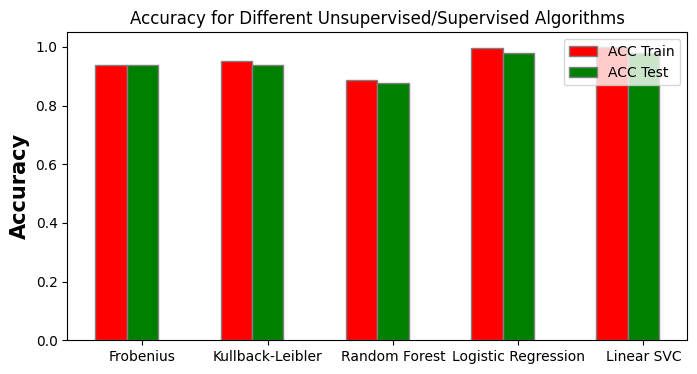

In [352]:

#############################
# Create Bar Chart for Accuracy Comparison
#############################

# Store Metrics from 3 models for test and train
algo = ["Frobenius","Kullback-Leibler","Random Forest", "Logistic Regression","Linear SVC"]

acc_test = [ks_fro, ks_kl, ks_rfc, ks_lr, ks_lsvc]
acc_train = [nmf_acc, nmf_kl_acc, rfc_acc, log_reg_acc, lsvc_acc]

# Create Bar Chart for accuracy


x = np.arange(len(algo))

barWidth = 0.25
fig, ax = plt.subplots(figsize =(8, 4)) 

 

# Set position of bar on X axis 
br1 = np.arange(len(acc_test)) 
br2 = [x + barWidth for x in br1] 

# Make the plot
plt.bar(br1, acc_train, color ='r', width = barWidth, 
        edgecolor ='grey', label ='ACC Train') 
plt.bar(br2, acc_test, color ='g', width = barWidth, 
        edgecolor ='grey', label ='ACC Test') 

# Adding Labels 
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(len(acc_test))],algo)
plt.title("Accuracy for Different Unsupervised/Supervised Algorithms")

plt.legend()
plt.show() 



### References

“Word Embeddings in NLP.” GeeksforGeeks, 11 Oct. 2020, www.geeksforgeeks.org/word-embeddings-in-nlp/.


riturajsaha. “Understanding TF-IDF (Term Frequency-Inverse Document Frequency).” GeeksforGeeks, 20 Jan. 2021, www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/.